kNN 알고리즘은 주변의 가까운 이웃들에게 물어봐서 대다수의 답변과 동일하게 답변하는 방법이다.  
그러나 3명에게 물어봤을 때 2명이 거짓으로 대답을 한다면 예측은 틀리게 된다. 서포트 벡터 머신(SVM)은 '지금 현재 이곳이 한강의 북쪽인가요? 남쪽인가요?'와 같이 질문해서 답변을 얻는 방법이다.
***
서포트 벡터라는 개넘은 한강의 위치를 찾는데 사용하는 개념으로 한강은 도시가 강북인지 강남인지를 구분하는 결정 경계선(decision boundary)이다. 서포트 벡터는 결정 경계선을 찾는데 사용되는 개졈이고 벡터는 2차원 공간상에 나타나는 데이터 포인트를 의미한다. 따라서, 서포트 벡터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.
***
서포트 벡터와 결정 경계선 사이의 거리를 마진이라고 하고 SVM의 목표는 마진을 최대로 하는 결정 경계선을 찾는 것이다.  
SVM에서는 약간의 오류를 허용하기 위해 비용(C)이라는 변수를 사용한다. 비용이 낮을수록 마진을 최대한 높이고 학습 에러율을 증가하는 방향으로 결정 경계선을 만들고 비용이 높을수록 마진은 낮아지고 학습 에러율은 감소하는 방향으로 결정 경계선을 만든다. 비용이 너무 낮으면 과소 적합의 위험이 있고 너무 높으면 과대 적합의 위험이 있으니 적절한 비용값을 찾는 과정이 상당히 중요하다.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data/basketball_stat.csv')
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
# df.head()
train, test = train_test_split(df, train_size=0.8, test_size=0.2)
# print(train.shape[0])
# print(test.shape[0])

커널 트릭(kernel trick)  
저차원 벡터 공간의 데이터를 고차원 벡터 공간으로 옮겨줌으로써 결정 경계선을 찾는 방법이다.  
저차원의 데이터를 고차원의 데이터로 옮겨주는 함수를 매핑 함수라 하고 매핑 함수를 가지고 많은 양의 데이터를 저차원에서 고차원으로 옮기기에는 계산량이 너무 많아서 현실적으로 사용하기 어렵다. 실제로 데이터를 고차원으로 보내지는 않지만 보낸 것과 동일한 효과를 줘서 빠른 속도로 결정 경계선을 찾는 방법이 고안되었으며 이를 커널 트릭이라 부른다.

최적의 SVM 파리미터 찾기  
SVM에서 RBF 커널 사용하므로 마진의 너비를 조정하는 파라미터(C)와 결정 경계선의 곡률을 조정하는 파라미터(gamma)를 알아야 한다.  
사이킷런의 그리드 서치(grid search)를 개발자가 부여한 비용과 감마의 후보들을 모두 조합해 최적의 비용과 감마값을 알아낸다.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

GridSearchCV() 함수의 실행 결과에 fit() 함수를 실행하면 그리드 서치를 사용해서 자동으로 최적의 파라미터를 찾아준다.

In [4]:
# 사이킷런에서 제공하는 GridSearchCV() 함수를 사용해 최적의 비용과 감마값을 알아내는 함수
def svm_param_selection(x, y, nfolds):
    # 비용과 감마값의 후보를 정한다.
    svm_parameters = [{'kernel': ['rbf'], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                      'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    # SVC => Support Vector Classification
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds)
    clf.fit(x, y.values.ravel())
    print('최고 점수: {}'.format(clf.best_score_))
    print('최고 점수를 낸 파라미터: {}'.format(clf.best_params_))
    print('최고 점수를 낸 파라미터를 가진 SVC 모델: {}'.format(clf.best_estimator_))
    return clf

In [5]:
x_train = train[['3P', 'BLK']] # 3점슛과 블로킹 횟수를 학습 데이터로 지정한다.
y_train = train[['Pos']]       # 포지션을 실제값으로 지정한다.
# 최적의 파라미터로 학습된 모델을 저장한다.
clf = svm_param_selection(x_train, y_train, 10)

최고 점수: 0.9625
최고 점수를 낸 파라미터: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
최고 점수를 낸 파라미터를 가진 SVC 모델: SVC(C=1, gamma=1)


결정 경계 시각화

In [6]:
# 최고 점수를 낸 파라미터를 이용해서 시각화 할 비용 후보들을 저장한다.
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)
print(C_canditates)

# 최고 점수를 낸 파라미터를 이용해서 시각화 할 감마 후보들을 저장한다.
gamma_canditates = []
gamma_canditates.append(clf.best_params_['gamma'] * 0.01)
gamma_canditates.append(clf.best_params_['gamma'])
gamma_canditates.append(clf.best_params_['gamma'] * 100)
print(gamma_canditates)

# 3점슛과 블로킹 횟수로 학습을 하고 학습 모델의 분류값으로 포지션을 지정한다.
X = train[['3P', 'BLK']]
# 데이터프레임에서 특정 열을 얻어올 때 얻어올 열을 []로 묶어서 얻어오면 데이터프레임 형태로 얻어오고 []로 묶지않고 얻어오면
# 시리즈 형태로 얻어온다.
# Y = train[['Pos']] # 데이터프레임 형태로 얻어온다.
# Y = train['Pos']   # 시리즈 형태로 얻어온다.
# tolist() 함수는 시리즈 타입의 데이터를 파이썬 리스트 타입으로 변환한다.
Y = train['Pos'].tolist()
print(type(Y))

[0.01, 1, 100]
[0.01, 1, 100]
<class 'list'>


시각화를 위해 포지션(센터: C => 0, 슈팅가드: SG => 1)을 숫자로 표현한다.

In [7]:
position = []
for i in Y:
    if i == 'C':
        position.append(0)
    else:
        position.append(1)
print(position)

[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]


In [8]:
# 최적의 파라미터 후보들을 조합해서 학습하고 학습된 모델들을 저장한다.
classifiers = []
for C in C_canditates:
    for gamma in gamma_canditates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))
classifiers

[(0.01, 0.01, SVC(C=0.01, gamma=0.01)),
 (0.01, 1, SVC(C=0.01, gamma=1)),
 (0.01, 100, SVC(C=0.01, gamma=100)),
 (1, 0.01, SVC(C=1, gamma=0.01)),
 (1, 1, SVC(C=1, gamma=1)),
 (1, 100, SVC(C=1, gamma=100)),
 (100, 0.01, SVC(C=100, gamma=0.01)),
 (100, 1, SVC(C=100, gamma=1)),
 (100, 100, SVC(C=100, gamma=100))]

In [9]:
import matplotlib as mpl
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 15
mpl.rcParams['axes.unicode_minus'] = False

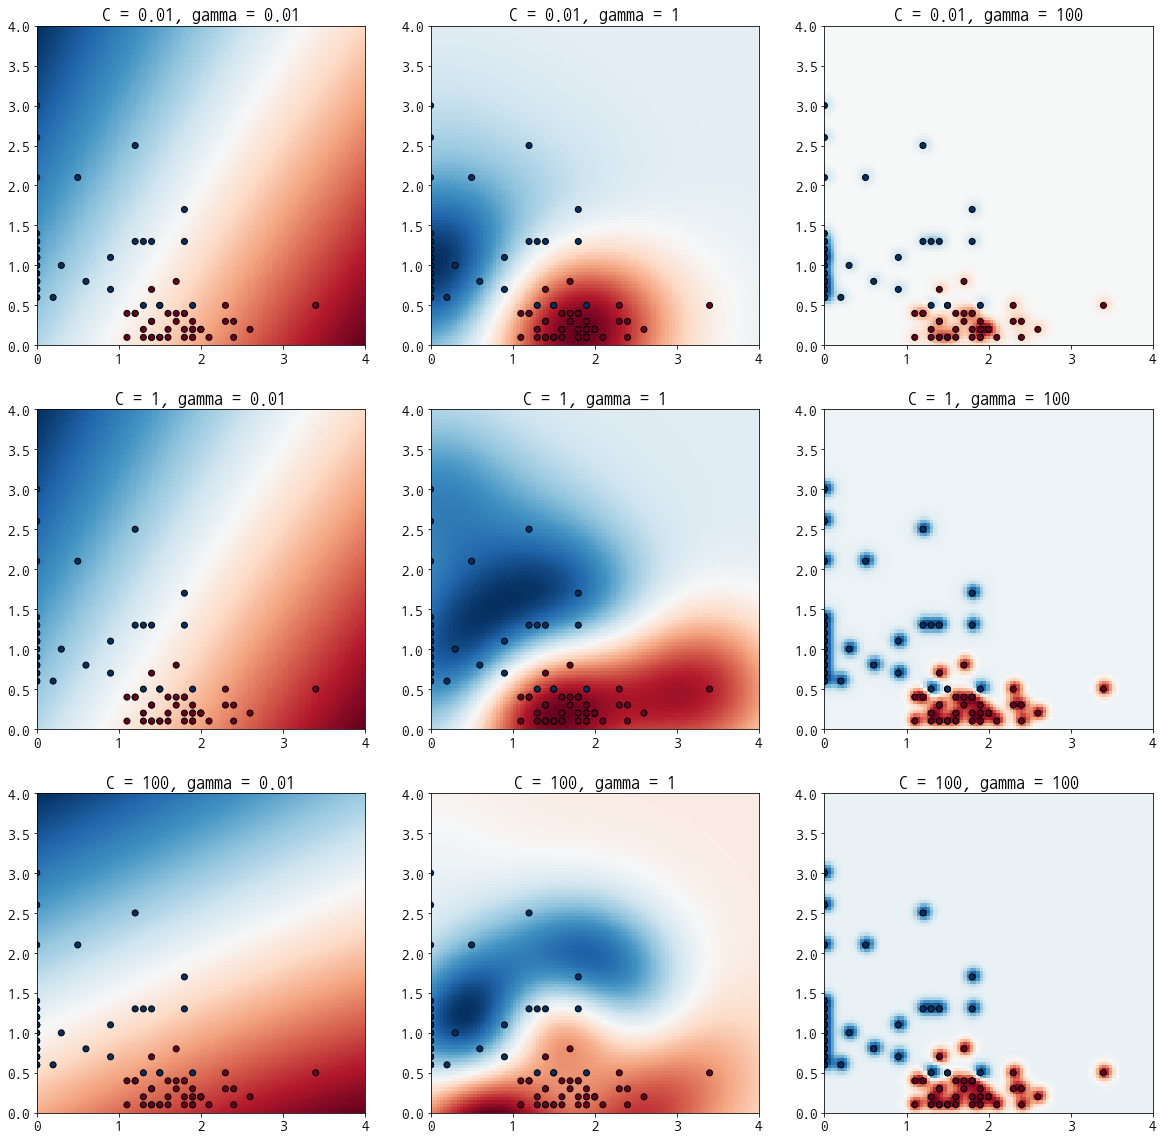

In [10]:
# 각 모델을 시각화 한다.
plt.figure(figsize=[20, 20])
# xx, yy는 0에서 4 사이를 100 단계로 나눈 넘파이 배열이다.
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

# enumerate() 함수는 인수로 지정된 리스트를 인덱스와 값 형태의 튜플로 리턴한다.
for i, (C, gamma, clf) in enumerate(classifiers):
    # print(i, (C, gamma, clf))
    
    # subplot 그래프: 두 개 이상의 그래프의 상관 관계를 효과적으로 표시할 수 있는 다단 그래프
    # subplot을 사용하는 방법은 subplot() 함수를 사용하여 그래프의 개수와 위치 정해주고 그래프는 plot() 함수로 그리면 된다.
    plt.subplot(len(C_canditates), len(gamma_canditates), i + 1)
    plt.title('C = {}, gamma = {}'.format(C, gamma))
    
    # 넘파이 배열을 옆으로, 아래로 붙이기: np.r_(), np.c_(), https://rfriend.tistory.com/352 참조
    # np.r_[a, b] => a, b 두 배열을 왼쪽에서 오른쪽으로 붙인다.
    # np.r_[[a], [b]] => a, b 두 배열을 위에서 아래로 붙인다.
    # np.c_[a, b] => 두 개의 1차원 배열을 붙여서 2차원 배열을 만든다.
    # 사이킷런 패키지의 decision_function() 함수는 판별 함수 값을 계산한다.
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # print(Z.shape)
    
    # pcolormesh() 함수는 cmap 속성으로 지정한 색상을 이용해 xx, yy로 지정된 단계로 Z에 저장된 결정 경계면을 표시한다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    # X['3P']를 x축으로 X['BLK']를 y축으로 cmap에서 지정한 색상(edgecolors는 테두리 색상)을 c속성으로 구분해서 그래프를 그린다.
    # cmap 속성값 => https://jrc-park.tistory.com/155 참조
    plt.scatter(x=X['3P'], y=X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')
    
plt.show()

9개의 차트 중 가운데 차트가 GridSearch를 통해 얻은 C와 gamma를 사용해 학습한 SVM 모델이며 균등하게 두 그룹이 분류된 것을 확인할 수 있다.  
결과 차트를 좌에서 우로 보면 감마의 크기에 따른 결정 경계의 곡률 변화를 확인할 수 있고 위에서 아래로 보면 C의 크기에 따른 결정 경계의 위치 변화를 확인할 수 있다.

모델 테스트

In [11]:
x_test = test[['3P', 'BLK']]
y_test = test['Pos']
# 최적의 파라미터로 학습된 모델로 테스트를 진행한다.
y_true, y_pred = y_test, clf.predict(x_test)
print('정확도: {}'.format(accuracy_score(y_true, y_pred)))

정확도: 0.9


In [13]:
#               precision    recall  f1-score   support  
# class 0            0.75      0.60      0.67         5  
# class 1            0.33      0.50      0.40         2  
#   
#     accuracy                           0.57         7  
#    macro avg       0.54      0.55      0.53         7  
# weighted avg       0.63      0.57      0.59         7  

# 위 결과에서 0이라고 예측한 데이터의 75%만 실제로 0이었고 1이라고 예측한 데이터의 33%만 실제로 1이었음을 알 수 있다.  
# 또한 실제 0인 데이터 중의 60%만 0으로 판별되었고 실제 1인 데이터 중의 50%만 1로 판별되었음을 알 수 있다.  
# accuracy : 정확도. 전체 학습데이터의 개수에서 각 클래스에서 자신의 클래스를 정확하게 맞춘 개수의 비율.  
# macro : 단순평균  
# weighted : 각 클래스에 속하는 표본의 갯수로 가중평균  

In [14]:
# 사이킷런 metrics 패키지에서는 정밀도, 재현율, F1 Score를 계산하는 classification_report() 함수를 제공한다.
# 이 함수는 정밀도, 재현율, F1 Score를 각각 계산하고 그 평균값으로 전체 모형의 성능을 평가한다.
# 정확도 : accuracy, 예측이 얼마나 정답과 정확한가?
# 정밀도 : precision, 예측한 것 중에서 정답의 비율
# 재현율 : recall, 찾아야 할 것 중에서 실제로 찾은 비율
# f1-score : 정밀도와 재현율의 조화 평균으로 f1-score 값이 높으면 성능이 높다고 할 수 있다.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           C       0.82      1.00      0.90         9
          SG       1.00      0.82      0.90        11

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20

